In [1]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=eb4eeea9f363e6ca4765dd8ece420d85c399914bc8309e18c2422f3761655a77
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import chess
import chess.pgn
from chess import Board, Move
from enum import Enum
from google.colab import drive
import io
import itertools
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Iterator, List

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class ChessMoveModel(nn.Module):
    def __init__(self, number_of_possible_moves):
        super(ChessMoveModel, self).__init__()

        # Convulutional Layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=2, kernel_size=3, stride=1, padding=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(8 * 8 * 2, 512)
        self.fc2 = nn.Linear(512, number_of_possible_moves)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1) # Flatten from (8, 8, 2) to (128,)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)           #  Output logits for the predicted move

        return x

In [6]:
# Load your trained model
model = ChessMoveModel(number_of_possible_moves=4612)
model.load_state_dict(torch.load('/content/drive/MyDrive/UNT/CSCE 5218/Semester Project/models/cnn.10.27.12.13.pytorch'))
model.eval()  # Set the model to evaluation mode

<ipython-input-6-2eb8da5b4e70>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/UNT/CSCE 5218/Semester Project/model

ChessMoveModel(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4612, bias=True)
)

In [15]:
def prepare_input_tensor(board: chess.Board) -> torch.Tensor:
    # Convert the board state to a PyTorch tensor (assuming get_board_array returns a NumPy array)
    board_tensor = torch.tensor(get_board_array(board), dtype=torch.float32)
    # Create a tensor for the player turn
    turn_tensor = torch.full((8, 8), 1 if board.turn == chess.WHITE else -1, dtype=torch.float32)

    # Stack board and turn tensors along the channel dimension
    input_tensor = torch.stack([board_tensor, turn_tensor], dim=0)  # Shape: (2, 8, 8)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension -> (1, 2, 8, 8)

    return input_tensor

In [10]:
# Define piece to integer mapping
piece_to_int = {
    None: 0,  # Empty square
    chess.PAWN: 1,
    chess.KNIGHT: 2,
    chess.BISHOP: 3,
    chess.ROOK: 4,
    chess.QUEEN: 5,
    chess.KING: 6
}

In [11]:
# Separate for white and black pieces
piece_to_int_white = {piece: val for piece, val in piece_to_int.items()}
piece_to_int_black = {piece: -val for piece, val in piece_to_int.items()}

In [12]:
def get_board_array(board: Board) -> np.ndarray:
    board_array = np.zeros((8, 8), dtype=int)

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece:
            row, col = divmod(square, 8)

            if piece.color == chess.WHITE:
                board_array[row, col] = piece_to_int_white[piece.piece_type]
            else:
                board_array[row, col] = piece_to_int_black[piece.piece_type]

    return board_array

In [21]:
def generate_all_possible_moves():
    file_path = "possible_moves.txt"

    with open(file_path, "r") as file:
        moves = file.readlines()

    return [move.strip() for move in moves]

In [ ]:
def generate_all_possible_moves():
    white_promotion_moves = []

    for file in FILES:
        for piece in PROMOTION_PIECES:
            white_promotion_moves.append(f"{file}7{file}8{piece}")

            for additional_file in FILES:
                if additional_file != file:
                    white_promotion_moves.append(f"{file}7{additional_file}8{piece}")

    return white_promotion_moves

In [24]:
POSSIBLE_MOVES = generate_all_possible_moves()

In [27]:
def get_move_mask(board: Board) -> np.ndarray:
    move_mask = np.zeros(len(POSSIBLE_MOVES))
    possible_moves = generate_all_possible_moves()

    legal_moves = list(board.legal_moves)

    legal_uci_moves = [move.uci().lower() for move in legal_moves]

    for i, move in enumerate(possible_moves):
        if move in legal_uci_moves:
            move_mask[i] = 1

    return move_mask

In [31]:
def make_move(board: Board) -> str:
  input_tensor = prepare_input_tensor(board)

  with torch.no_grad():
      outputs = model(input_tensor)  # Shape: (1, num_possible_moves)

  outputs

  # Generate the legal move mask for the current board state
  move_mask = get_move_mask(board)   # Legal move mask

  # Apply the mask to the outputs
  masked_outputs = outputs * torch.tensor(move_mask, dtype=torch.float32)

  # Get the best move index
  _, best_move_index = masked_outputs.max(dim=1)

  # Map the best move index back to UCI format
  predicted_move = POSSIBLE_MOVES[best_move_index.item()]

  return predicted_move

In [36]:
def human_move(board: Board, move: str) -> Board:
  move = chess.Move.from_uci(move)
  board.push(move)

  return board

In [37]:
def computer_move(board: Board) -> Board:
  move = make_move(board)
  board.push(chess.Move.from_uci(move))

  return board

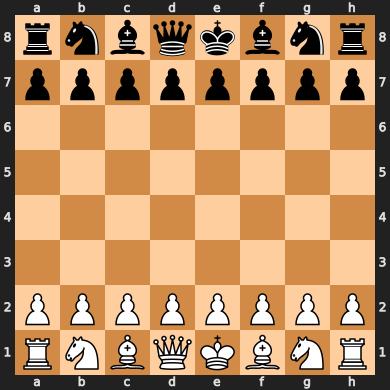

In [8]:
# Create a new chess board (starting position)
board = chess.Board()
board

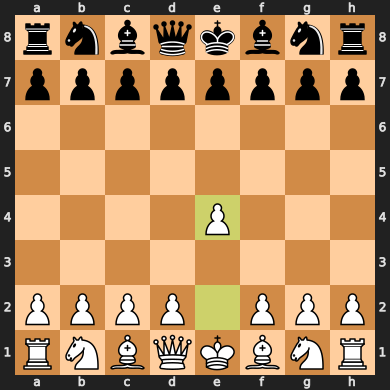

In [9]:
move = chess.Move.from_uci("e2e4")
board.push(move)
board

In [32]:
move = make_move(board)
move

'd7d6'

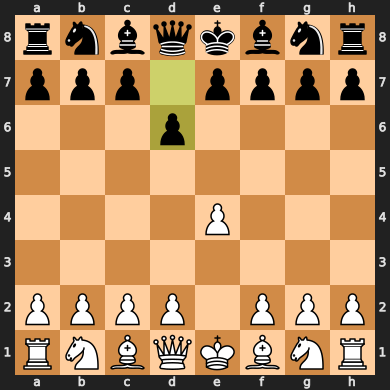

In [34]:
board.push(chess.Move.from_uci(move))
board

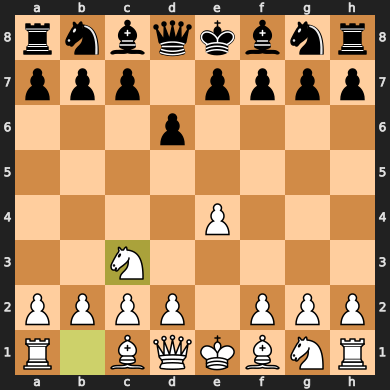

In [38]:
human_move(board, "b1c3")

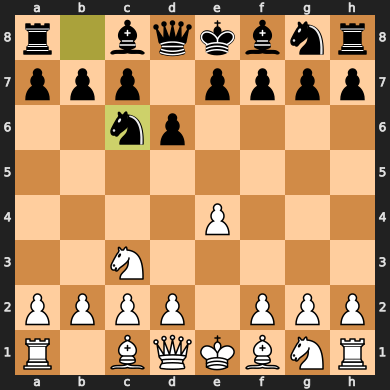

In [40]:
computer_move(board)

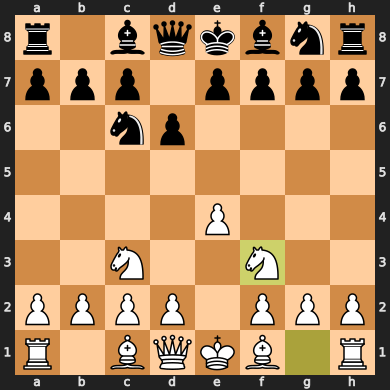

In [43]:
human_move(board, "g1f3")

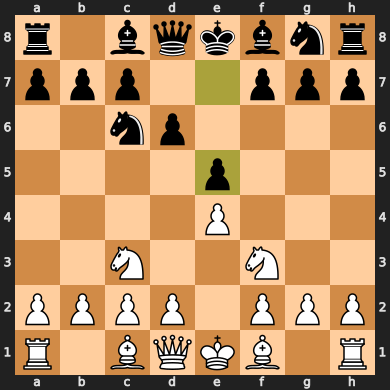

In [44]:
computer_move(board)

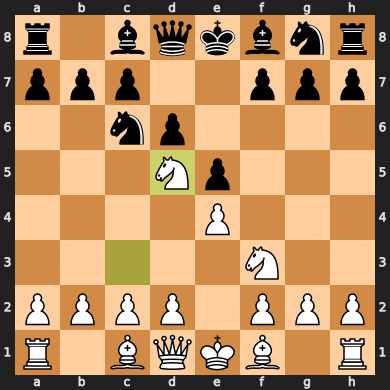

In [45]:
human_move(board, "c3d5")

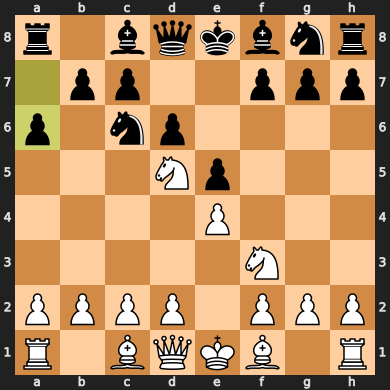

In [46]:
computer_move(board)

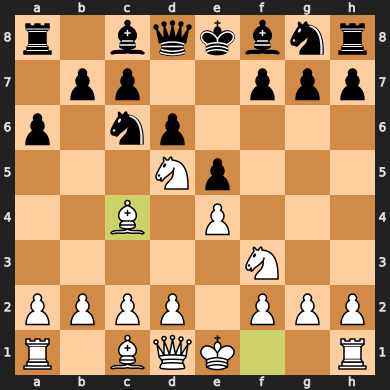

In [47]:
human_move(board, "f1c4")

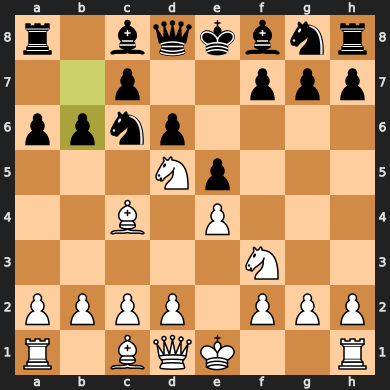

In [48]:
computer_move(board)

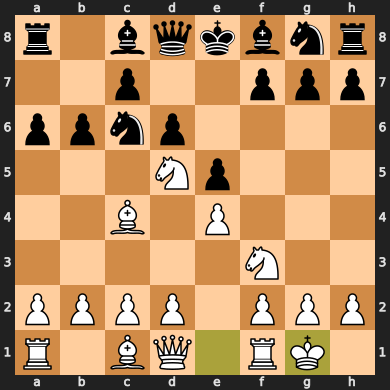

In [49]:
human_move(board, "e1g1")

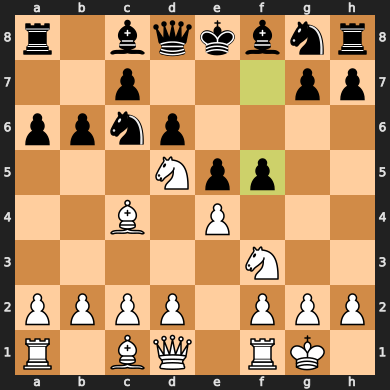

In [50]:
computer_move(board)

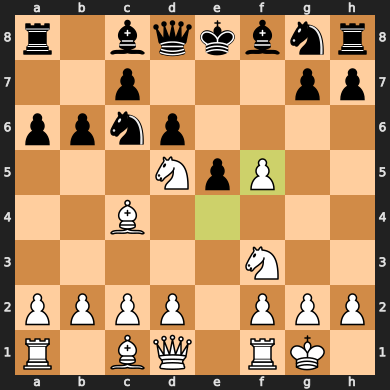

In [51]:
human_move(board, "e4f5")

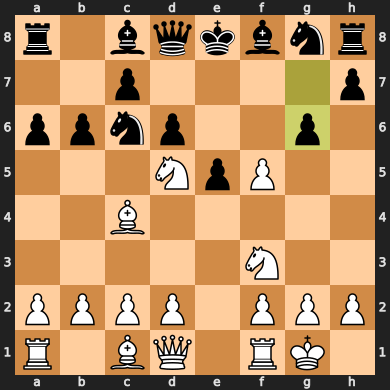

In [52]:
computer_move(board)

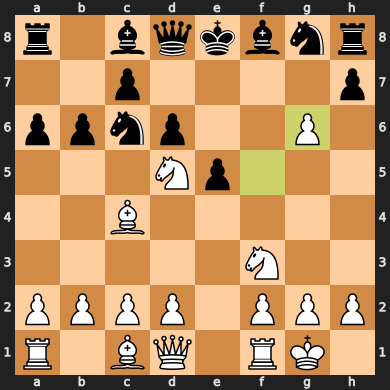

In [53]:
human_move(board, "f5g6")

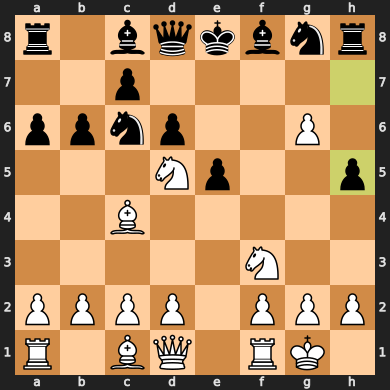

In [54]:
computer_move(board)

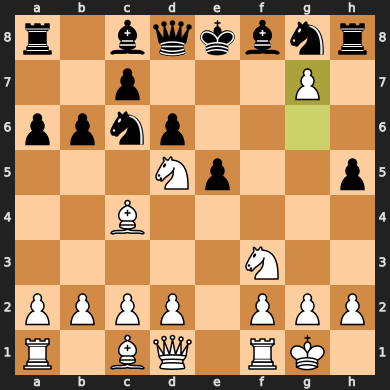

In [55]:
human_move(board, "g6g7")

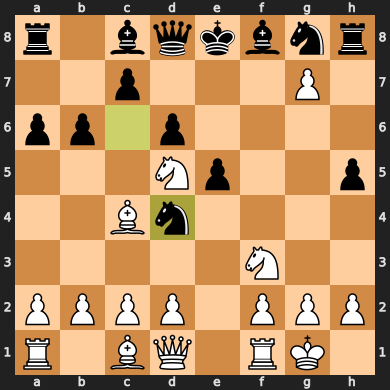

In [56]:
computer_move(board)